# Assignment 4 - dimensionality reduction

This assignment focuses on two different ways for dimensionality reduction:
* feature selection
* feature extraction

This assignment has weighting $1.5$.

# Sequential feature selection (50 points)

There is a sample code in PML chapter 4 for sequential bardward selection (SBS) and its application to subsequent KNN classifier.

Implement sequential forward selection (SFS), and compare it with sequential backward selection by plotting the accuracy versus the number of features.

You can start with the sample code provided in the [slides](http://nbviewer.jupyter.org/github/1iyiwei/pyml/blob/master/code/ch04/ch04.ipynb).
You can extend the existing SBS class to handle both forward and backward selection, or implement a separate class for SFS.
Plot and compare the two accuracy versus number-of-features plots for SFS and SBS.

Use the wine dataset as follows.

In [1]:
import pandas as pd

wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_remote,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

#print('Class labels', np.unique(df_wine['Class label']))
#df_wine.head()

In [2]:
from sklearn import __version__ as skv
from distutils.version import LooseVersion as CheckVersion
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [3]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Answer

Implement your sequential backward selection class here, either as a separate class or by extending the SBS class that can handle both forward and backward selection (via an input parameter to indicate the direction).

In [4]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score

class SeqSearch():
    def __init__(self, estimator, k_features, direction, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if direction == "SBS" or direction == "sbs":
            self.direction = 0
        else:
            self.direction = 1

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        if self.direction == 0:
            
            dim = X_train.shape[1]
            self.indices_ = tuple(range(dim))
            self.subsets_ = [self.indices_]
            score = self._calc_score(X_train, y_train, 
                                     X_test, y_test, self.indices_)
            self.scores_ = [score]
            
            while dim > self.k_features:
                scores = []
                subsets = []

                for p in combinations(self.indices_, r=dim - 1):
                    score = self._calc_score(X_train, y_train, 
                                             X_test, y_test, p)
                    scores.append(score)
                    subsets.append(p)

                best = np.argmax(scores)
                self.indices_ = subsets[best]
                self.subsets_.append(self.indices_)
                dim -= 1

                self.scores_.append(scores[best])
            self.k_score_ = self.scores_[-1]
            
        else:
            
            dim = 0
            self.indices_ = tuple(range(X_train.shape[1]))
            self.subsets_ = []
            self.scores_ = []
            
            while dim < self.k_features:
                scores = []
                subsets = []
                new_features = []
                if dim == 0:
                    pre_subset = [];
                else:
                    pre_subset = self.subsets_[dim-1]

                for p in combinations(self.indices_, r=1):
                    subset = list(pre_subset)
                    subset.append(p[0])
                    score = self._calc_score(X_train, y_train, 
                                             X_test, y_test, tuple(subset))
                    scores.append(score)
                    subsets.append(subset)
                    new_features.append(p[0])
                
                best = np.argmax(scores)
                self.indices_ = tuple(x for x in self.indices_ if x != new_features[best])
                self.subsets_.append(subsets[best])
                dim += 1

                self.scores_.append(scores[best])
                
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Apply your sequential forward/backward selection code to the KNN classifier with the wine data set, and plot the accuracy versus number-of-features curves for both.
Describe the similarities and differences you can find, e.g. 
* do the two methods agree on the optimal number of features?
* do the two methods have similar accuracy scores for each number of features?
* etc.

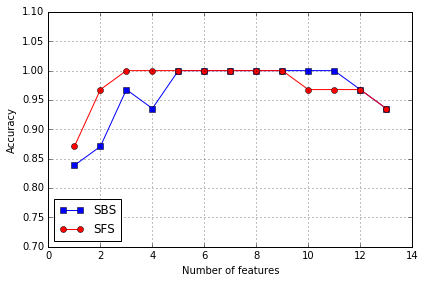

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')
Index(['Color intensity', 'Alcohol', 'Total phenols'], dtype='object')


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SeqSearch(knn, k_features=1, direction="SBS")
sbs.fit(X_train_std, y_train)

# selecting features
sfs = SeqSearch(knn, k_features=13, direction="SFS")
sfs.fit(X_train_std, y_train)

# plotting performance of feature subsets

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='s', color='b', label="SBS")

k_feat = [len(k) for k in sfs.subsets_]
plt.plot(k_feat, sfs.scores_, marker='o', color='r', label="SFS")

plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

print (df_wine.columns[1:][list(sbs.subsets_[8])])
print (df_wine.columns[1:][list(sfs.subsets_[2])])

### Findings
In sample practice, SFS result has the optimal number of features as <b>3</b> and SBS has <b>5</b>, which means they will not always agree on the "optimal number of features", although they could be the same. Furthermore, the features chosed by selecting are very different from each other. 

SBS is worse than SFS at the end of its selecting (i.e. when number of features is small) and SFS is also worse than SBS near the end of its selecting (i.e. when number of features is near the total dimension). SFS is likely to increase more quickly when the optimal number of features is small, while SBS could be more unstable at the situation.

However, it can be inferred from the graph that the two methods have similar accuracy scores for each number of features, and their trendency according to the number of features are similar too. For both methods, the optimal accuray scores can be very close to 1.

# PCA versus LDA (50 points)

We have learned two different methods for feature extraction, PCA (unsupervised) and LDA (supervised).

Under what circumstances would PCA and LDA produce very different results? 

Provide one example dataset in 2D, analyze it via PCA and LDA, and plot it with the PCA and LDA components.

You can use code from the scikit-learn library.

## Answer

Write code to produce your own dataset in 2D.
You are free to design relative characteristics like the number of class, the number of samples for each class, as long as your dataset could be analyzed via PCA and LDA.

In [6]:
label = [1]*50 + [2]*50 + [3]*50

feature1 = [round(np.random.normal(2, 0.5),4) for i in range(50)]
feature1 += [round(np.random.normal(5, 0.5),4) for i in range(50)]
feature1 += [round(np.random.normal(8, 0.5),4) for i in range(50)]

feature2 = [round(np.random.normal(3, 2),4) for i in range(150)]

d = [label, feature1, feature2]
d = np.transpose(d)

df_test = pd.DataFrame(data=d)
df_test.columns = ['label', 'feature1', 'feature2']
# print (df_test)

X, y = df_test.iloc[:, 1:].values, df_test.iloc[:, 0].values
X_std = stdsc.fit_transform(X)

Plot your data set, with different classes in different marker colors and/or shapes.

You can write your own plot code or use existing library plot code.

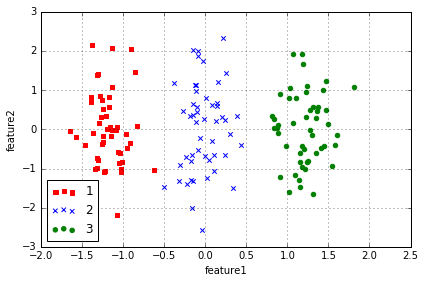

In [7]:
%matplotlib inline
index = range(1, 4)
markers = ['s', 'x', 'o']
colors = ['r', 'b', 'g']

for i, m, c in zip(index, markers, colors):
    plt.scatter(X_std[y == i, 0], X_std[y == i, 1], marker=m, color=c, label=int(i))
    
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

Apply your dataset through PCA and LDA, and plot the projected data using the same plot code.
Explain the differences you notice, and how you manage to construct your dataset to achieve such differences.

You can use the PCA and LDA code from the scikit-learn library.

In [8]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(p=2)

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

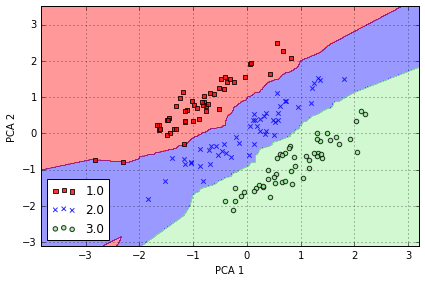

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# for i, m, c in zip(index, markers, colors):
#     plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], marker=m, color=c, label=int(i))

knn.fit(X_pca, y)
plot_decision_regions(X_pca, y, classifier=knn, resolution=0.01)
    
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

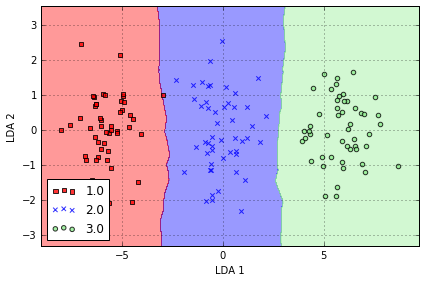

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_std, y)

# for i, m, c in zip(index, markers, colors):
#     plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], marker=m, color=c, label=int(i))
    
knn.fit(X_lda, y)
plot_decision_regions(X_lda, y, classifier=knn, resolution=0.01)
    
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

### Conclusion
As we can see the knn fitting result and in the above two graph, PCA performaces much worse than LDA does when the feature of data is most in one dimension. The PCA analytic result in 1D is too close to each other, as a result, the knn fitting result after PCA is likely to be over fitted. While the LDA handle the situation well. 

When I construct the dataset, I try to make the class category mainly dependent on merely one feature(i.e. feature1).

<center> - END - </center>